## Import Modules

In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import matplotlib.pyplot as plt

## 모델 로드

In [2]:
model = deeplabv3_resnet101(pretrained=True).eval()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 이미지 로드

In [3]:
image_paths = [
    "/Users/jian_lee/Desktop/aiffel/data/human_segmentation/images/IMG_6309.jpg",
    "/Users/jian_lee/Desktop/aiffel/data/human_segmentation/images/Cat.jpg",
    "/Users/jian_lee/Desktop/aiffel/data/human_segmentation/images/크로마키.jpg"
]

output_dir = "/Users/jian_lee/Desktop/aiffel/data/human_segmentation/images/"

## Step 1: 배경 흐림 적용

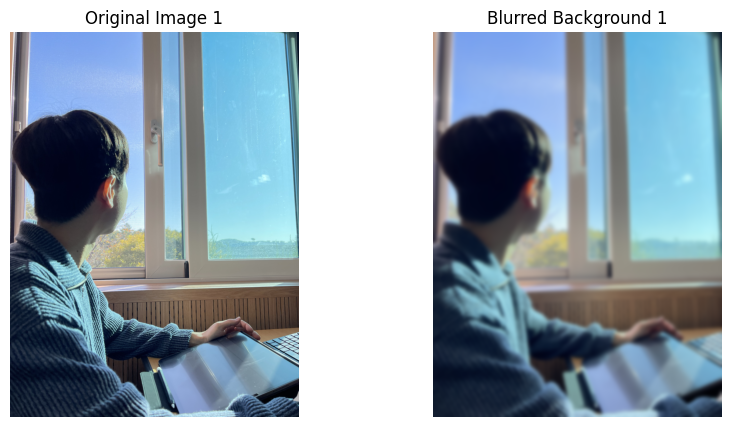

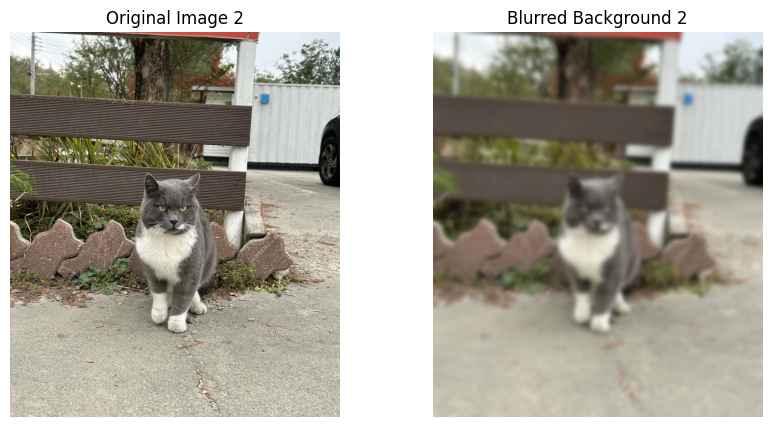

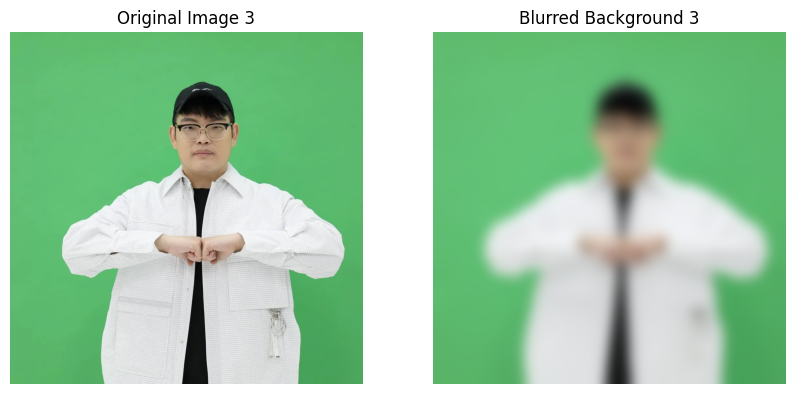

In [4]:
# 이미지 리스트를 반복문으로 순회하면서 처리
for idx, image_path in enumerate(image_paths):

    # ================== 1️⃣ 원본 이미지 로드 및 전처리 ==================
    # OpenCV를 사용하여 이미지 파일을 읽어오기 (BGR 형식으로 로드됨)
    image = cv2.imread(image_path)

    # OpenCV는 기본적으로 BGR 형식이므로, 이를 RGB로 변환하여 저장
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환

    # ================== 2️⃣ 배경 흐림 효과 적용 (Shallow Focus) ==================
    # 가우시안 블러 (Gaussian Blur)를 사용하여 배경을 흐리게 처리
    # (125, 125)는 커널 크기 (클수록 더 흐려짐), 0은 표준편차를 자동 계산
    blurred_background = cv2.GaussianBlur(image, (125, 125), 0)

    # ================== 3️⃣ 블러 처리된 이미지 저장 ==================
    # 흐린 배경 이미지를 저장할 경로 설정
    blurred_image_path = f"{output_dir}blurred_image_{idx}.jpg"

    # OpenCV는 기본적으로 BGR 형식이므로, 다시 BGR로 변환한 후 저장
    cv2.imwrite(blurred_image_path, cv2.cvtColor(blurred_background, cv2.COLOR_RGB2BGR))

    # ================== 4️⃣ 결과 시각화 ==================
    # 이미지 비교를 위해 Matplotlib을 사용하여 결과 출력
    plt.figure(figsize=(10, 5))  # 전체 출력 크기 설정 (가로 10인치, 세로 5인치)

    # (1) 원본 이미지 출력
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 칸
    plt.imshow(image)  # RGB 형식의 원본 이미지 출력
    plt.title(f"Original Image {idx+1}")  # 제목 추가
    plt.axis("off")  # 축(좌표값) 숨기기

    # (2) 흐려진 배경 이미지 출력
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 칸
    plt.imshow(blurred_background)  # 흐려진 배경 이미지 출력
    plt.title(f"Blurred Background {idx+1}")  # 제목 추가
    plt.axis("off")  # 축(좌표값) 숨기기

    # Matplotlib을 사용하여 최종 이미지 출력
    plt.show()

## Step 2: 배경과 인물 분리

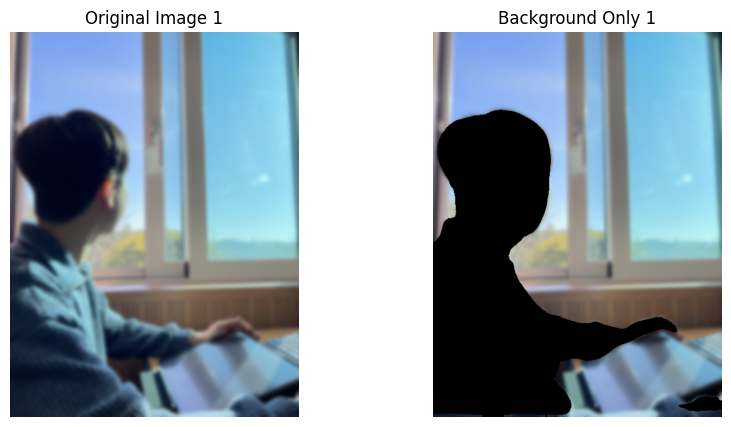

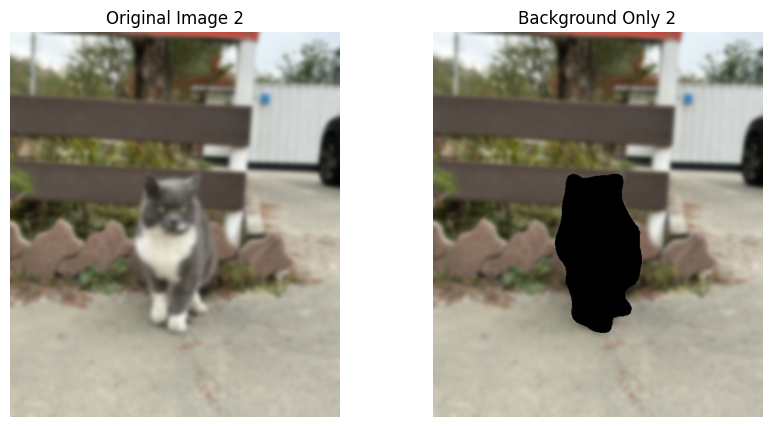

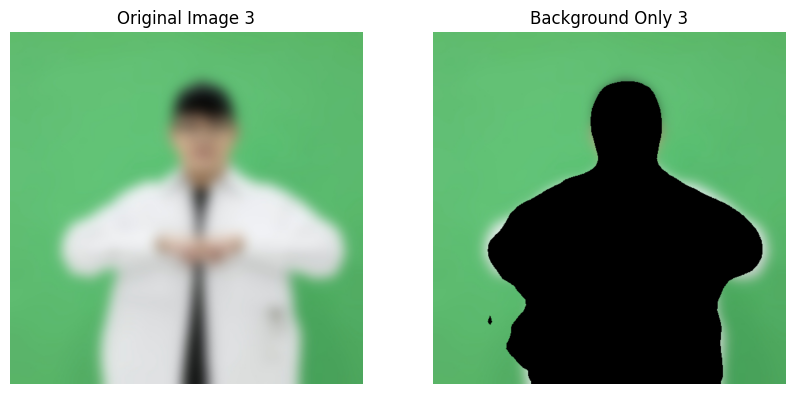

In [5]:
# 3장의 이미지에 대해 반복하여 처리
for idx in range(3):  

    # ================== 1️⃣ 흐린 배경 이미지를 로드 ==================
    blurred_image_path = f"{output_dir}blurred_image_{idx}.jpg"  # 흐린 배경 이미지 경로 지정
    
    # Pillow(PIL) 라이브러리를 사용하여 흐려진 이미지를 로드
    input_image = Image.open(blurred_image_path).convert("RGB")  # RGB 변환

    # 원본 이미지 크기 저장 (나중에 마스크를 원본 크기로 맞추기 위해 필요)
    original_size = input_image.size  # (width, height)

    # ================== 2️⃣ 이미지 전처리 (DeepLabV3 입력 형식에 맞춤) ==================
    transform = T.Compose([
        T.Resize(520),  # 모델이 요구하는 입력 크기로 리사이징
        T.ToTensor(),  # 이미지 데이터를 PyTorch 텐서 형태로 변환
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지 정규화
    ])
    
    # 변환 적용 후 배치 차원 추가 (모델이 배치 형태로 입력을 받기 때문)
    input_tensor = transform(input_image).unsqueeze(0)

    # ================== 3️⃣ DeepLabV3 모델을 사용하여 세그멘테이션 수행 ==================
    with torch.no_grad():  # 모델을 평가 모드로 실행 (역전파 비활성화, 메모리 절약)
        output = model(input_tensor)['out'][0]  # 예측 결과 획득

    # 출력 결과에서 가장 높은 확률을 가진 클래스 선택 (각 픽셀별 클래스 예측값)
    mask = output.argmax(0).byte().cpu().numpy()  # NumPy 배열로 변환

    # ================== 4️⃣ 사람(15번)과 고양이(8번) 클래스만 마스크 생성 ==================
    mask = ((mask == 15) | (mask == 8)).astype(np.uint8) * 255  # 사람 또는 고양이면 255(흰색), 아니면 0(검은색)

    # ================== 5️⃣ 마스크를 원본 크기로 리사이징 ==================
    mask_resized = cv2.resize(mask, original_size, interpolation=cv2.INTER_NEAREST)  # 원본 크기로 조정

    # ================== 6️⃣ OpenCV 형식으로 변환 (배경과 인물 분리) ==================
    # PIL 이미지를 OpenCV 포맷(BGR)으로 변환
    image_cv = cv2.cvtColor(np.array(input_image), cv2.COLOR_RGB2BGR)

    # 마스크도 OpenCV 형식의 NumPy 배열로 변환
    mask_cv = mask_resized.astype(np.uint8)

    # ================== 7️⃣ 배경만 남기고 인물(고양이) 제거 ==================
    # OpenCV의 비트 연산을 이용하여 배경만 남기고 인물 부분은 검게 만듦
    img_bg = cv2.bitwise_and(image_cv, image_cv, mask=(255 - mask_cv))

    # ================== 8️⃣ 배경 제거된 이미지 저장 ==================
    bg_result_path = f"{output_dir}background_only_{idx}.png"
    cv2.imwrite(bg_result_path, img_bg)  # OpenCV 형식으로 저장

    # ================== 9️⃣ 결과 시각화 ==================
    plt.figure(figsize=(10, 5))  # 출력 크기 설정 (가로 10인치, 세로 5인치)

    # (1) 원본 이미지 출력
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 칸
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))  # RGB 형식으로 변환하여 표시
    plt.title(f"Original Image {idx+1}")  # 제목 추가
    plt.axis("off")  # 축 숨기기

    # (2) 배경만 남긴 이미지 출력
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 칸
    plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))  # RGB 형식으로 변환하여 표시
    plt.title(f"Background Only {idx+1}")  # 제목 추가
    plt.axis("off")  # 축 숨기기

    # Matplotlib을 사용하여 최종 이미지 출력
    plt.show()

## Step 3: 최종 아웃 포커스 효과 적용

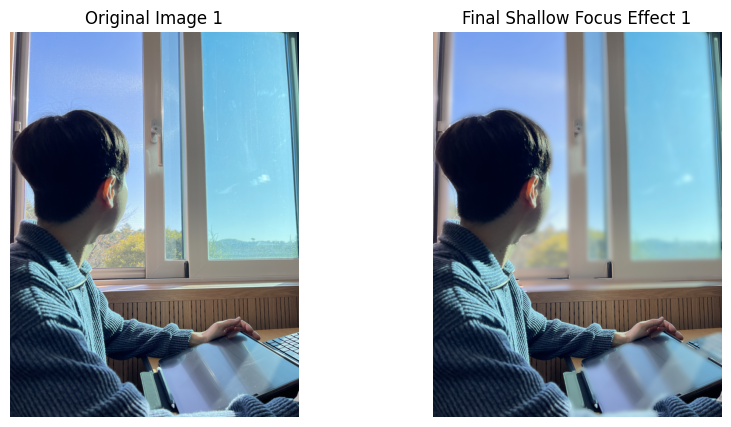

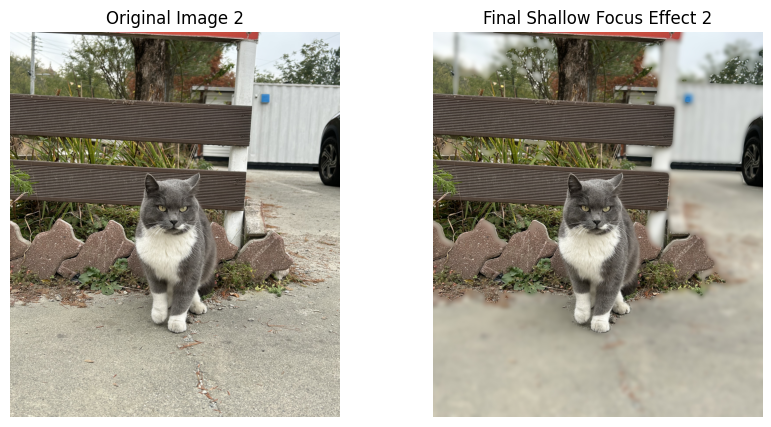

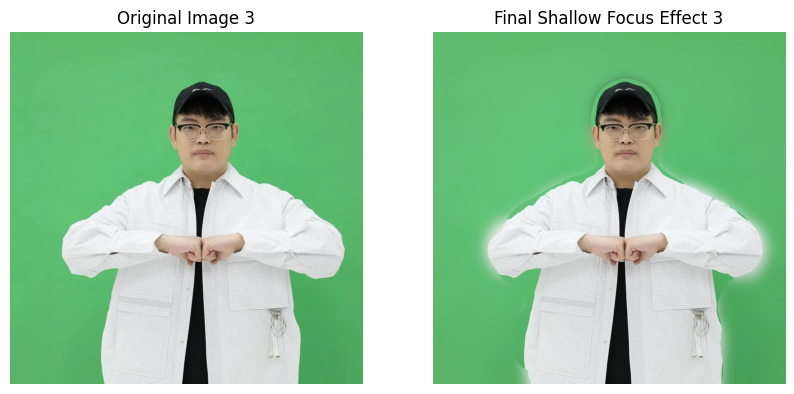

In [6]:
# 3장의 이미지에 대해 반복적으로 처리
for idx in range(3):  

    # ================== 1️⃣ 원본 및 블러 이미지, 마스크 로드 ==================
    
    # (1) 원본 이미지 로드
    image_path = image_paths[idx]  # 원본 이미지 경로
    image = cv2.imread(image_path)  # 이미지 로드 (BGR 형식)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환 (Matplotlib 표시용)

    # (2) 흐려진 배경 이미지 로드
    blurred_image_path = f"{output_dir}blurred_image_{idx}.jpg"
    blurred_background = cv2.imread(blurred_image_path)  # 블러 처리된 이미지 로드 (BGR)
    blurred_background = cv2.cvtColor(blurred_background, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

    # (3) 마스크 이미지 로드 (배경만 남긴 이미지)
    mask_path = f"{output_dir}background_only_{idx}.png"
    mask_cv = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # 마스크는 흑백(Grayscale)로 로드

    # ================== 2️⃣ 마스크 처리 (이진화 및 반전) ==================
    
    # (1) 마스크 이진화 처리 (threshold 적용)
    # 배경(255)과 인물/고양이(0)로 구분
    _, binary_mask = cv2.threshold(mask_cv, 128, 255, cv2.THRESH_BINARY)

    # (2) 마스크 반전 (인물/고양이: 255, 배경: 0)
    inverted_mask = cv2.bitwise_not(binary_mask)

    # (3) 마스크를 3채널로 변환 (RGB 이미지와 연산을 위해 필요)
    binary_mask_3ch = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2BGR) // 255  # 0~1 스케일로 정규화

    # ================== 3️⃣ 배경 블러 & 인물 유지 ==================
    
    # (1) 인물(또는 고양이) 영역은 원본 유지
    foreground = image * binary_mask_3ch  

    # (2) 배경 영역만 흐리게 적용
    background = blurred_background * (1 - binary_mask_3ch)

    # (3) 최종 합성: 배경은 흐리게, 인물은 선명하게 유지
    result = foreground + background  

    # ================== 4️⃣ 최종 결과 저장 ==================
    result_path = f"{output_dir}final_shallow_focus_{idx}.jpg"
    cv2.imwrite(result_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))  # OpenCV는 BGR이므로 변환 후 저장

    # ================== 5️⃣ 최종 결과 시각화 ==================
    
    plt.figure(figsize=(10, 5))  # 전체 그래프 크기 설정

    # (1) 원본 이미지 출력
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image {idx+1}")  # 제목 추가
    plt.axis("off")  # 축 숨기기

    # (2) 최종 셸로우 포커스 적용 이미지 출력
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(f"Final Shallow Focus Effect {idx+1}")  # 제목 추가
    plt.axis("off")  # 축 숨기기

    # 결과 출력
    plt.show()

## Step 4: 세그멘테이션 오류 강조

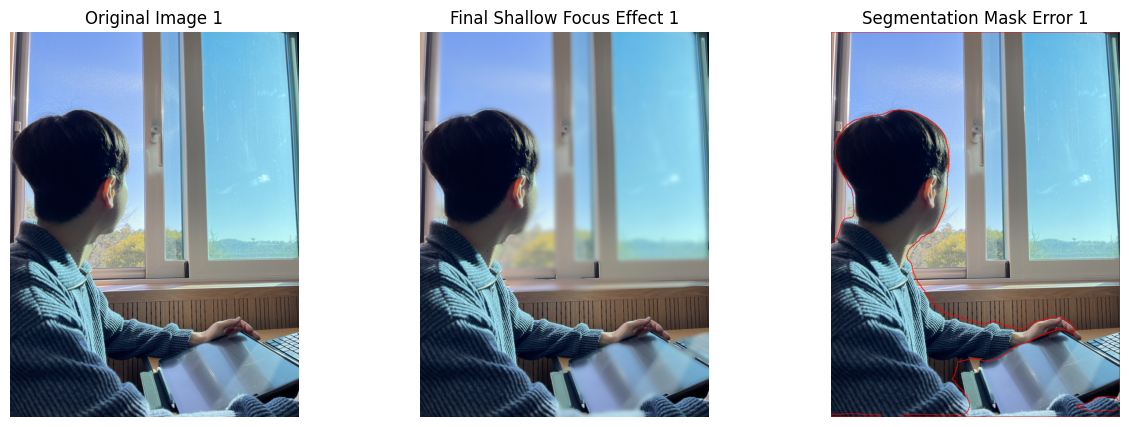

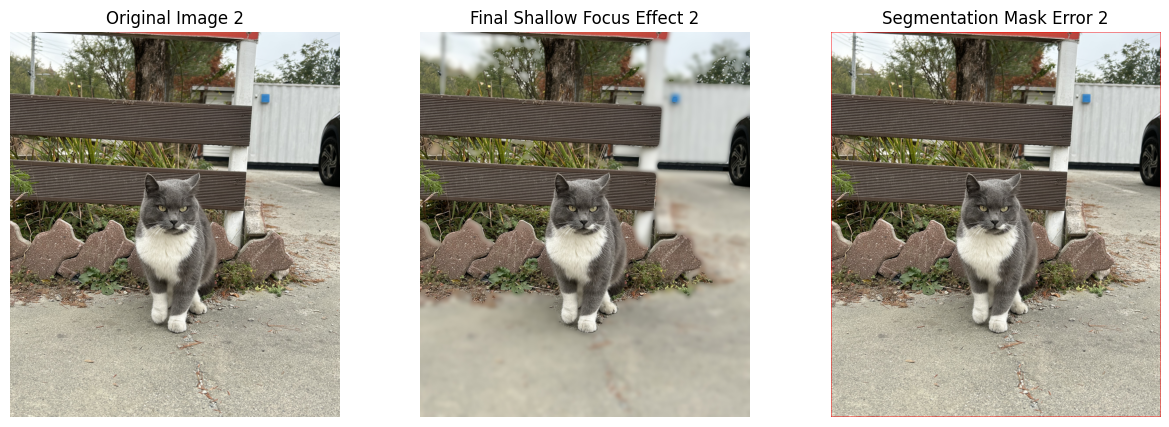

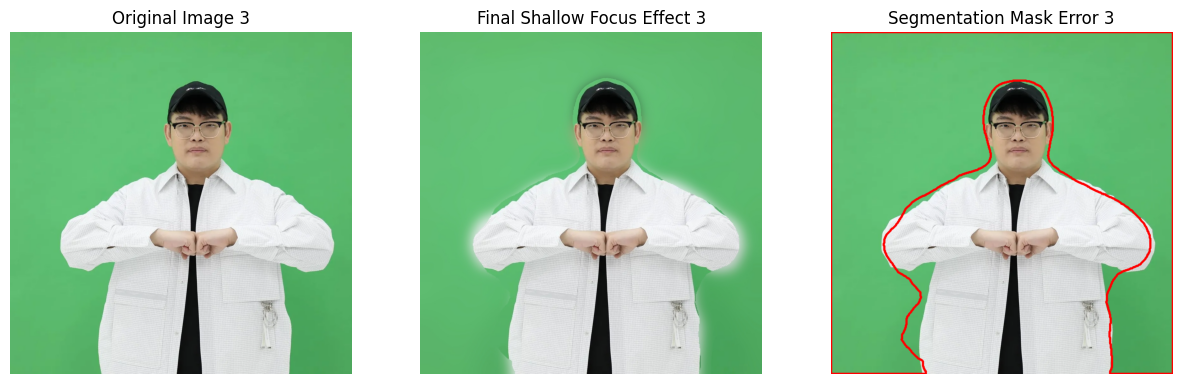

In [7]:
# 3장의 이미지에 대해 반복적으로 처리
for idx in range(3):  

    # ================== 1️⃣ 원본 및 최종 이미지, 마스크 로드 ==================
    
    # (1) 원본 이미지 로드
    image_path = image_paths[idx]  # 원본 이미지 경로
    image = cv2.imread(image_path)  # OpenCV로 이미지 로드 (BGR 형식)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환 (Matplotlib 표시용)

    # (2) 최종 Shallow Focus 이미지 로드 (아웃포커싱 적용 결과)
    result_path = f"{output_dir}final_shallow_focus_{idx}.jpg"
    result_image = cv2.imread(result_path)  # OpenCV로 이미지 로드 (BGR 형식)
    result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

    # (3) 마스크 이미지 로드 (배경만 남긴 이미지)
    mask_path = f"{output_dir}background_only_{idx}.png"
    mask_cv = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # 마스크를 흑백(Grayscale)으로 로드

    # ================== 2️⃣ 마스크 윤곽선 검출 ==================
    
    # (1) 마스크에서 윤곽선(contours) 추출
    # cv2.RETR_EXTERNAL: 외곽선만 찾음 (중첩되지 않도록)
    # cv2.CHAIN_APPROX_SIMPLE: 윤곽선의 점 개수를 줄여서 최적화
    contours, _ = cv2.findContours(mask_cv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # (2) 원본 이미지에 윤곽선 덧씌우기 (세그멘테이션 오류 강조)
    mask_highlighted = image.copy()  # 원본 이미지 복사 (수정 방지)
    if contours:
        cv2.drawContours(mask_highlighted, contours, -1, (255, 0, 0), 5)  # 🔴 윤곽선 두께 5로 설정 (빨간색 강조)

    # ================== 3️⃣ 윤곽선 검증 (고양이 세그멘테이션 문제 확인) ==================

    # (1) 윤곽선이 검출되지 않은 경우 경고 메시지 출력
    if len(contours) == 0:
        print(f"[Warning] Image {idx+1}: 윤곽선이 제대로 감지되지 않았습니다.")

    # (2) 윤곽선이 너무 작다면 세그멘테이션 마스크가 잘못 생성된 것으로 판단
    elif max(cv2.contourArea(cnt) for cnt in contours) < 100:
        print(f"[Warning] Image {idx+1}: 윤곽선이 너무 작습니다. 마스크를 확인하세요.")

    # ================== 4️⃣ 최종 결과 시각화 (원본 → 최종 아웃포커싱 → 세그멘테이션 오류) ==================
    
    plt.figure(figsize=(15, 5))  # 전체 그래프 크기 설정

    # (1) 원본 이미지 출력
    plt.subplot(1, 3, 1)  # 1행 3열 중 첫 번째 칸
    plt.imshow(image)
    plt.title(f"Original Image {idx+1}")  # 제목 추가
    plt.axis("off")  # 축 숨기기

    # (2) 최종 Shallow Focus 적용 이미지 출력
    plt.subplot(1, 3, 2)  # 1행 3열 중 두 번째 칸
    plt.imshow(result_image)
    plt.title(f"Final Shallow Focus Effect {idx+1}")  # 제목 추가
    plt.axis("off")  # 축 숨기기

    # (3) 윤곽선 강조된 마스크 출력 (세그멘테이션 오류 확인)
    plt.subplot(1, 3, 3)  # 1행 3열 중 세 번째 칸
    plt.imshow(mask_highlighted)
    plt.title(f"Segmentation Mask Error {idx+1}")  # 제목 추가
    plt.axis("off")  # 축 숨기기

    # 결과 출력
    plt.show()

-  원본 vs 최종 아웃포커싱 vs 세그멘테이션

    - 첫 번째 인물 사진
        - 팔 부분이 제대로 안됐고, 특히 오른쪽 팔 부분이 빛으로 인해 잘되지 않았음.

    - 두 번째 동물 사진
        - 처음에 누끼는 잘 땄으나, 아웃포커스가 잘 잡히지 않았고 에러를 표기할때도 오류가 있음.
        
    - 세 번째 크로마키 사진
        - 전반적으로 잘 되었으나, 팔 아래쪽이 잘되지 않은 모습을 보임.

## 솔루션

- 현재 DeepLabV3를 사용하여 인물과 배경을 분리하고 있지만, 이미지(특히 고양이)에서 오류가 발생

1.	빠르고 정확한 솔루션
    - SAM 적용
2.	이미지 품질을 유지하고 싶다면
    - HRNet
3.	기존 모델을 유지하면서 보정하려면
    - GrabCut + CRF 후처리
4.	최고의 성능을 원한다면
    - DeepLabV3 + U^2-Net 결합

## 회고

- 오늘 솔루션까지 진행하기에는 시간이 조금 모자랐음.

- 시간을 조금 더 투자해 솔루션을 적용해보고자 함. 